In [1]:
import torch
import numpy as np
import einops
import matplotlib.pyplot as plt

from tqdm import tqdm

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost, stl_control_cost_aug, vargrad_control_cost

from cfollmer.drifts import SimpleForwardNetBN, AbstractDrift
from cfollmer.sampler_utils import FollmerSDE, FollmerSDE_STL

from functools import partial

In [2]:
!pip install einops

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def log_p(mus, sigma2, x):
    # x : [b, 2]
    # mus : [n, 2]

    # I need x - mus : [b, n,]
    dist_to_means = torch.cdist(x, mus)**2
    out = torch.logsumexp(-dist_to_means / (2 * sigma2), 1)
#     print(out.shape)
    return out # [..., None]

In [5]:
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-5, 5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

In [49]:
d = 1.0
sigma2 = 0.05
mus_full = torch.tensor([
    [- d, 0.0],
    [- d, d],
    [- d, -d],
    [- d, 2 * d],
    [- d, - 2 * d],
#     [- 4 * d, 0.0],
#     [- 4 * d, d],
#     [- 4 * d, -d],
#     [- 4 * d, 2 * d],
#     [- 4 * d, - 2 * d],
    [d, 0.0],
    [d, d],
    [d, -d],
    [d, 2 * d],
    [d, - 2 * d],
#     [4 * d, 0.0],
#     [4 * d, d],
#     [4 * d, -d],
#     [4 * d, 2 * d],
#     [4 * d, - 2 * d],
], device=device)

mus_farthest = torch.tensor([
    [- 4 * d, 0.0],
    [- 4 * d, d],
    [- 4 * d, -d],
    [- 4 * d, 2 * d],
    [- 4 * d, - 2 * d],
    [4 * d, 0.0],
    [4 * d, d],
    [4 * d, -d],
    [4 * d, 2 * d],
    [4 * d, - 2 * d],
], device=device)

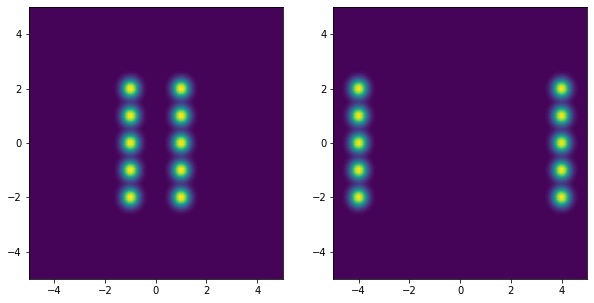

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_distribution(mus_full, sigma2, axes[0])
plot_distribution(mus_farthest, sigma2, axes[1])

In [51]:
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [404]:
class SimpleForwardNetStoch(AbstractDrift):

    def __init__(self, input_dim=1, width=20):
        super(SimpleForwardNetStoch, self).__init__()

        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.ReLU(),
            torch.nn.Linear(width, width), torch.nn.ReLU(),
            torch.nn.Linear(width, width), torch.nn.ReLU(),
            torch.nn.Linear(width, width), torch.nn.ReLU(),
            torch.nn.Linear(width, input_dim),
        )
        
#         self.nnt = torch.nn.Sequential(
#             torch.nn.Linear(1, width), torch.nn.ReLU(),
#             torch.nn.Linear(width, width), torch.nn.ReLU(),
#             torch.nn.Linear(width, width), torch.nn.ReLU(),
#             torch.nn.Linear(width, width), torch.nn.ReLU(),
#             torch.nn.Linear(width, input_dim),
#         )
        self.N = int(1.0 / dt)
        self.dt = dt 
#         self.ws = torch.normal(mean=0, std=0.01, size=(self.N , self.input_dim, self.input_dim)).to(device)
        
        self.nn[-1].weight.data.fill_(0.0)
        self.nn[-1].bias.data.fill_(0.0)
#         self.nn[-1].weight.data = torch.randn_like(self.nn[-1].weight.data) 
#         self.nn[-1].weight.data =  self.nn[-1].weight.data  * 1
#         self.nn[-1].bias.data =  torch.randn_like(self.nn[-1].bias.data) # * 10
        
    def forward(self, x, t):
        # t needs the same shape as x (except for the final dim, which is 1)
        
    #         import pdb; pdb.set_trace()
        t_ = (t * self.N).type(torch.int32).min()
#         import pdb; pdb.set_trace()
#         w = self.ws[t_-1]
#         iport


        x = torch.cat((x, t), dim=-1)
        nn_sde =  self.nn(x)

    #         nn_out = super().forward(x, t)
    # #         ababa
    #         return nn_out
#         print(self.nn[-1].weight.data.min(), self.nn[-1].weight.data.max())
#         print(nn_sde.mean(dim=0), nn_sde.std(dim=0))
        return nn_sde


In [618]:
import torchsde
import math
import copy

class FollmerSDE(torch.nn.Module):

    def __init__(self, gamma, drift_network):
        super().__init__()

        self.noise_type = 'diagonal'
        self.sde_type = 'ito'
        self.gamma = gamma
        self.drift_network = drift_network
        self.drift_network_detatched = copy.deepcopy(drift_network)
        self.dim = drift_network.input_dim
        
    def f(self, t, y, detach=False):
        t_ = t * torch.ones((y.shape[0], 1), device=y.device)
        if detach:
            return self.drift_network_detatched(y, t_)
        return self.drift_network(y, t_)
        
    def g(self, t, y):
        return torch.sqrt(self.gamma * torch.ones_like(y))

    def sample_trajectory(self, batch_size, dt=0.05, device=None, mode=None):
        param_init = torch.zeros((batch_size, self.dim), device=device)

        n_steps = int(1.0 / dt)
        
        
        if mode is None:
            ts = torch.linspace(0, 1, n_steps, device=device)
        else:
            exp = 4
            base = torch.linspace(0 ** exp, 1 ** exp,  n_steps, device=device)
            ts = torch.pow(base, 1.0 / exp)

        param_trajectory = torchsde.sdeint(self, param_init, ts, method="euler", dt=dt)

        return param_trajectory, ts

    def sample(self, batch_size, dt=0.05, device=None, mode=None):
        return self.sample_trajectory(batch_size, dt=dt, device=device,mode=mode)[0][-1]

In [685]:
from typing import Callable, Optional

import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np
from functorch import vmap


fake_net = lambda x,t: torch.zeros_like(x)
fake_net.input_dim = 2

# fake_net = SimpleForwardNetStoch(input_dim=2, width=300)
brown =  FollmerSDE(gamma, fake_net).to(device)

def vargrad_control_cost(
        sde: torch.nn.Module,
        log_p: Callable,
        param_batch_size: Optional[int] = 32,
        dt: Optional[float] = 0.05,
        device: Optional[torch.device] = None,
    ):
    """
    Note this is implemented in the most naive way following  Eq 49 (prop 3.10) 
    in Nüsken and Ritchter a more efficient implementation would augment the 
    state-space as we disccused just currently racing through this.

    paper : https://arxiv.org/pdf/2005.05409.pdf
    Objective for the VarGrad (Nüsken et al. 2020) Hamilton-Bellman-Jacobi Follmer Sampler
    """

    with torch.no_grad():
        
        param_trajectory, ts = sde.sample_trajectory(param_batch_size, dt=dt, device=device, mode=None) # mode="exp")
        param_T = param_trajectory[-1]
    
    dX = param_trajectory[1:, ...] - param_trajectory[:-1, ...]
    dt_ = ts[1:, ...] - ts[:-1, ...]
    
    # dX = v dt + \sqrt{gamma} dW
    # u . v dt +  u .  dW \sqrt{gamma} 
    # u . dX 
    # (u . v dt +  u .  dW \sqrt{gamma} ) / gamma = u . v dt / gamma +   u .  dW / \sqrt{gamma}
    # \sqrt{\gamma}  /{\gamma} = 1/\sqrt{gamma} quick sanith check
    
    # Has shape [T, batch_size, dim]
    # Note: this is essentially evaluated twice (once before in sdeint call).
    # Could adjust torchsde to return the drift as an extra parameter (seems that there's
    # no way currently)
    
    us = vmap(sde.f)(ts[:-1, ...], param_trajectory[:-1, ...])

    # Costs
    energy_cost = torch.sum(us**2 * dt_ [:,None,None], dim=[0, 2])   / (2 * sde.gamma)
    ito_plus_cross_term = torch.einsum("ijk,ijk->j", us , dX) / sde.gamma

    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * sde.gamma) - log_p(param_T)

    Y_T = energy_cost - ito_plus_cross_term

    return torch.var(Y_T - terminal_cost, unbiased=True)


def relative_entropy_control_cost(
        sde: torch.nn.Module,
        log_p: Callable,
        param_batch_size: Optional[int] = 32,
        dt: Optional[float] = 0.05,
        device: Optional[torch.device] = None,
    ):
    """
    Objective for the Hamilton-Bellman-Jacobi Follmer Sampler
    """

    param_trajectory, ts = sde.sample_trajectory(param_batch_size, dt=dt, device=device)
    param_T = param_trajectory[-1]

    # Has shape [T, batch_size, dim]
    # Note: this is essentially evaluated twice (once before in sdeint call).
    # Could adjust torchsde to return the drift as an extra parameter (seems that there's
    # no way currently)
    us = vmap(sde.f)(ts[:-1, ...], param_trajectory[:-1, ...])

    # Not sure if this terminology is correct so feel free to correct
    energy_cost = torch.sum(us**2, dim=[0, 2]) * dt  / (2 * sde.gamma)
    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * sde.gamma) - log_p(param_T)

    return torch.mean(energy_cost + terminal_cost)


def train(gamma, n_iterations, param_batch_size, log_p, dt=0.05, stl=False):
    
#     sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    
    if stl:
        sde = FollmerSDE_STL(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    else:
        sde = FollmerSDE(gamma, SimpleForwardNetStoch(input_dim=2, width=300)).to(device)
    
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []
    sdes = []
    
    for _ in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        
        if stl:
            loss = stl_control_cost_aug(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        else:
            alpha = 0.5
            loss = (alpha* relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device) +
                   vargrad_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device) *(1-alpha))
#             loss = vargrad_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
        if _ % 1000 == 0:
            sdes.append(copy.deepcopy(sde))
    
    losses = np.array(losses)
    
    return sde, losses, sdes

In [686]:
#  SimpleForwardNetBN(input_dim=2, width=300).input_dim

In [ ]:
gamma = 0.23
n_iterations = 2000
param_batch_size = 128

stl  = False
log_p_full = partial(log_p, mus_full, sigma2)
dt =0.05
n_iterations = 2000

n_iterations = 20000
# n_iterations = 25000
sde, losses, sdes = train(gamma, n_iterations, param_batch_size, log_p_full, dt=dt, stl=stl)

 14%|█▎        | 2717/20000 [22:19<2:19:22,  2.07it/s]

In [674]:
losses;

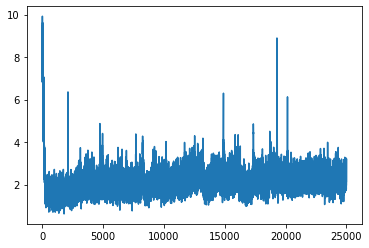

In [677]:
plt.plot(losses)

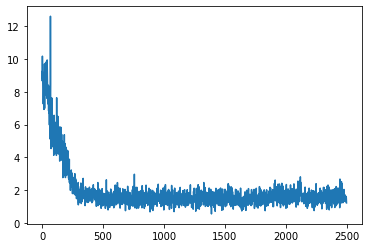

In [669]:
plt.plot(losses)

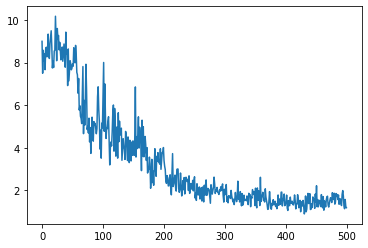

In [651]:
plt.plot(losses)

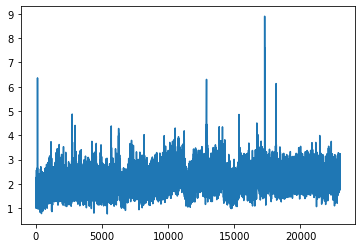

In [678]:
plt.plot(losses[2000:]) # STL

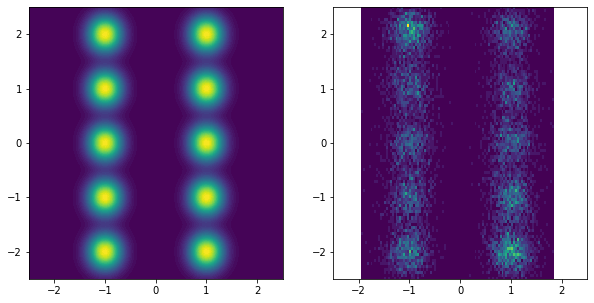

In [696]:
with torch.no_grad():
    samples = sde.sample(10000, dt=0.01, device=device, mode="exp")
    samples = samples.cpu().numpy()
    
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-2.5, 2.5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plot_distribution(mus_full, sigma2, axes[0])
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

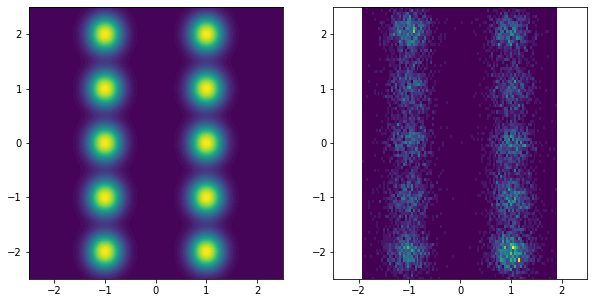

In [697]:
with torch.no_grad():
    samples = sde.sample(10000, dt=0.01, device=device, mode=None)
    samples = samples.cpu().numpy()
    
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-2.5, 2.5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plot_distribution(mus_full, sigma2, axes[0])
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

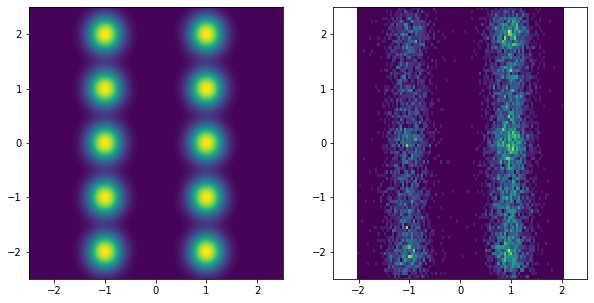

In [458]:
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-2.5, 2.5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plot_distribution(mus_full, sigma2, axes[0])
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [516]:
tms =  torch.linspace(0, 1, int(1/dt))

a = 0.2
etms = torch.exp(a*tms) / torch.exp(a*tms).max()
etms
etms[1:] - etms[:-1], tms[1:] - tms[:-1]

(tensor([0.0087, 0.0088, 0.0088, 0.0089, 0.0090, 0.0091, 0.0092, 0.0093, 0.0094,
         0.0095, 0.0096, 0.0097, 0.0098, 0.0099, 0.0100, 0.0101, 0.0103, 0.0104,
         0.0105]),
 tensor([0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526,
         0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526,
         0.0526]))

In [635]:
torch.linspace(0, 1, int(1/dt))

tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])

In [537]:
exp =4

base = np.linspace(0 ** exp, 1 ** exp,  int(1/dt) + 1)
etms = torch.pow(torch.FloatTensor(base), 1.0 / exp)
print(etms)
etms[1:] - etms[:-1], tms[1:] - tms[:-1]

tensor([0.0000, 0.4729, 0.5623, 0.6223, 0.6687, 0.7071, 0.7401, 0.7692, 0.7953,
        0.8190, 0.8409, 0.8612, 0.8801, 0.8979, 0.9147, 0.9306, 0.9457, 0.9602,
        0.9740, 0.9873, 1.0000])


(tensor([0.4729, 0.0895, 0.0600, 0.0464, 0.0384, 0.0330, 0.0291, 0.0261, 0.0238,
         0.0219, 0.0203, 0.0189, 0.0178, 0.0168, 0.0159, 0.0151, 0.0144, 0.0138,
         0.0133, 0.0127]),
 tensor([0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526,
         0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526, 0.0526,
         0.0526]))

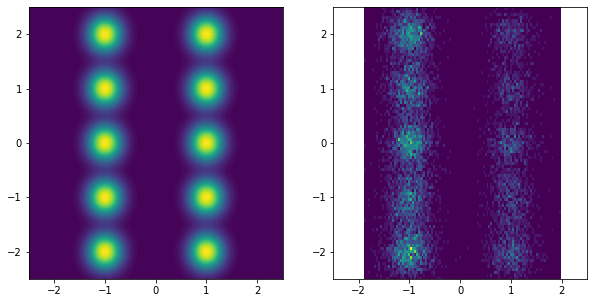

In [523]:
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-2.5, 2.5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plot_distribution(mus_full, sigma2, axes[0])
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

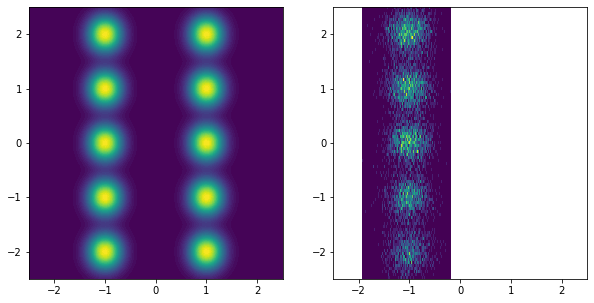

In [198]:
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-2.5, 2.5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plot_distribution(mus_full, sigma2, axes[0])
# plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [ ]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.01)

In [ ]:
log_p_full = partial(log_p, mus_farthest, sigma2)
sde, losses = train(gamma, 1000, param_batch_size, log_p_full, dt=0.05)

In [ ]:
with torch.no_grad():
    samples = sde.sample(100000, dt=0.01, device=device)
    samples = samples.cpu().numpy()

In [ ]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [356]:
sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
dt = 0.05

(-5.0, 5.0)

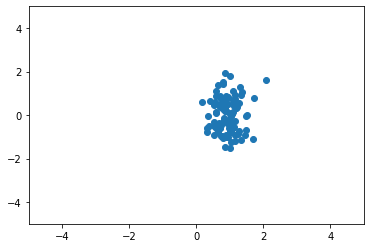

In [403]:
optimizer.zero_grad()
        
loss = relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
loss.backward()

optimizer.step()

with torch.no_grad():
    samples = sde.sample(100, dt=0.01, device=device)
    samples = samples.cpu().numpy()
    
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)